In [2]:
#This script pulls in WHO datasets for New cases and new deaths from COVID-19, builds and tests several predictive models, and subsequently makes predictions for mortality rates. A comparison is done between lockdown and social distancing approaches to the pandemic using the best model.

# author = 'Dr Adaeze Nwobodo' email = 'AdaezeNwobodo@gmail.com'

#import library packages {caret/Dplyr/lubridate/mgcv/purrr/ranger/rpart/rpart.plot/sigr/tidyselect/tidyverse/wrapr/base/broom/cluster/datasets/ellipsis/ggplot2/graphics/grDevices/highr/lattice/maggritr/methods/nlme/ readr/readxl/renv/stats/stringr/tibble/tidyr/utils}

In [3]:
# DEFINE HELPER FUNCTIONS 

In [4]:
# 1
load_file <- function(filename) {
    #loads csv into dataframe
    return (read_csv(filename))
}
    
print(load_file)

function(filename) {
    #loads csv into dataframe
    return (read_csv(filename))
}


In [ ]:
#Import libraries 
library(dplyr) 
library(ggplot2) 
library(tidyr) 
library(caret) 
library(lubridate) 
library(purrr)
library(mgcv)
library(rpart)
install.packages("sigr"); library(sigr)
library(tidyverse)
library(tidyselect)
library(utils)
library(base)
library(broom)
library(cluster)
library(ellipsis)
library(graphics)
library(grDevices)
library(highr)
library(lattice)
library(methods)
library(nlme)
library(readr)
library(readxl)
library(stats)
library(stringr)
install.packages("vtreat"); library(vtreat)
library(tibble)
install.packages("xgboost"); library(xgboost)
library(randomForest)
library(magrittr)
install.packages("Metrics"); library(Metrics)
install.packages("zoo"); library(xts)

In [8]:
WHO_COVID19 <- load_file("WHO-COVID-19-global-data.csv")

Parsed with column specification:
cols(
  Date_reported = col_character(),
  Country_code = col_character(),
  Country = col_character(),
  WHO_region = col_character(),
  New_cases = col_double(),
  Cumulative_cases = col_double(),
  New_deaths = col_double(),
  Cumulative_deaths = col_double()
)


In [9]:
head(WHO_COVID19, n = 5)

Date_reported,Country_code,Country,WHO_region,New_cases,Cumulative_cases,New_deaths,Cumulative_deaths
03/01/2020,AF,Afghanistan,EMRO,0,0,0,0
04/01/2020,AF,Afghanistan,EMRO,0,0,0,0
05/01/2020,AF,Afghanistan,EMRO,0,0,0,0
06/01/2020,AF,Afghanistan,EMRO,0,0,0,0
07/01/2020,AF,Afghanistan,EMRO,0,0,0,0


In [10]:
# Structure of the COVID datasets
str(WHO_COVID19)

tibble [71,675 x 8] (S3: spec_tbl_df/tbl_df/tbl/data.frame)
 $ Date_reported    : chr [1:71675] "03/01/2020" "04/01/2020" "05/01/2020" "06/01/2020" ...
 $ Country_code     : chr [1:71675] "AF" "AF" "AF" "AF" ...
 $ Country          : chr [1:71675] "Afghanistan" "Afghanistan" "Afghanistan" "Afghanistan" ...
 $ WHO_region       : chr [1:71675] "EMRO" "EMRO" "EMRO" "EMRO" ...
 $ New_cases        : num [1:71675] 0 0 0 0 0 0 0 0 0 0 ...
 $ Cumulative_cases : num [1:71675] 0 0 0 0 0 0 0 0 0 0 ...
 $ New_deaths       : num [1:71675] 0 0 0 0 0 0 0 0 0 0 ...
 $ Cumulative_deaths: num [1:71675] 0 0 0 0 0 0 0 0 0 0 ...
 - attr(*, "spec")=
  .. cols(
  ..   Date_reported = col_character(),
  ..   Country_code = col_character(),
  ..   Country = col_character(),
  ..   WHO_region = col_character(),
  ..   New_cases = col_double(),
  ..   Cumulative_cases = col_double(),
  ..   New_deaths = col_double(),
  ..   Cumulative_deaths = col_double()
  .. )


In [19]:
#Class of dates column
class(WHO_COVID19$Date_reported)

[1] "Date"

In [36]:
#Filter out UK datasets 
WHO_COVID19_UK <- WHO_COVID19 %>%
    filter(Country == "The United Kingdom")
head(WHO_COVID19_UK)

Date_reported,Country_code,Country,WHO_region,New_cases,Cumulative_cases,New_deaths,Cumulative_deaths
0003-01-20,GB,The United Kingdom,EURO,0,0,0,0
0004-01-20,GB,The United Kingdom,EURO,0,0,0,0
0005-01-20,GB,The United Kingdom,EURO,0,0,0,0
0006-01-20,GB,The United Kingdom,EURO,0,0,0,0
0007-01-20,GB,The United Kingdom,EURO,0,0,0,0
0008-01-20,GB,The United Kingdom,EURO,0,0,0,0


In [37]:
#Remove 3 columns - "Country_code", "Country" and "WHO_region"
WHO_COVID19_UK <- WHO_COVID19_UK %>%
    select(-Country_code, -Country, -WHO_region)

In [38]:
#View dataset
head(WHO_COVID19_UK, n = 5)

Date_reported,New_cases,Cumulative_cases,New_deaths,Cumulative_deaths
0003-01-20,0,0,0,0
0004-01-20,0,0,0,0
0005-01-20,0,0,0,0
0006-01-20,0,0,0,0
0007-01-20,0,0,0,0


In [39]:
# Convert Date_reported column to time-based column (to convert to xts object)
WHO_COVID19_UK$Date_reported <- as.Date(WHO_COVID19_UK$Date_reported)

In [40]:
#Convert WHO_COVID19_UK to an xts object
WHO_COVID19_UK_xts <- as.xts(WHO_COVID19_UK[ , -1], order.by = WHO_COVID19_UK$Date_reported)

In [41]:
#Check the class of WHO_COVID19_UK_xts
class(WHO_COVID19_UK_xts)

[1] "xts" "zoo"

In [42]:
#Examine first 5 lines of WHO_COVID19_UK_xts
head(WHO_COVID19_UK_xts, n = 5)

           New_cases Cumulative_cases New_deaths Cumulative_deaths
0001-02-20         2                2          0                 0
0001-03-20        12               42          0                 0
0001-04-20      4273            33954        403              2453
0001-05-20      5446           172596        634             26683
0001-06-20      1125           255519         60             37445

In [43]:
#EXPLORATION OF THE WHO_COVID19_UK_xts DATA

In [44]:
#Identify the periodicity of WHO_COVID19_UK_xts
periodicity(WHO_COVID19_UK_xts)

Monthly periodicity from 0001-02-20 to 0031-10-20 

In [49]:
#Number of periods in WHO_COVID19_UK_xts
ndays(WHO_COVID19_UK_xts)

[1] 305

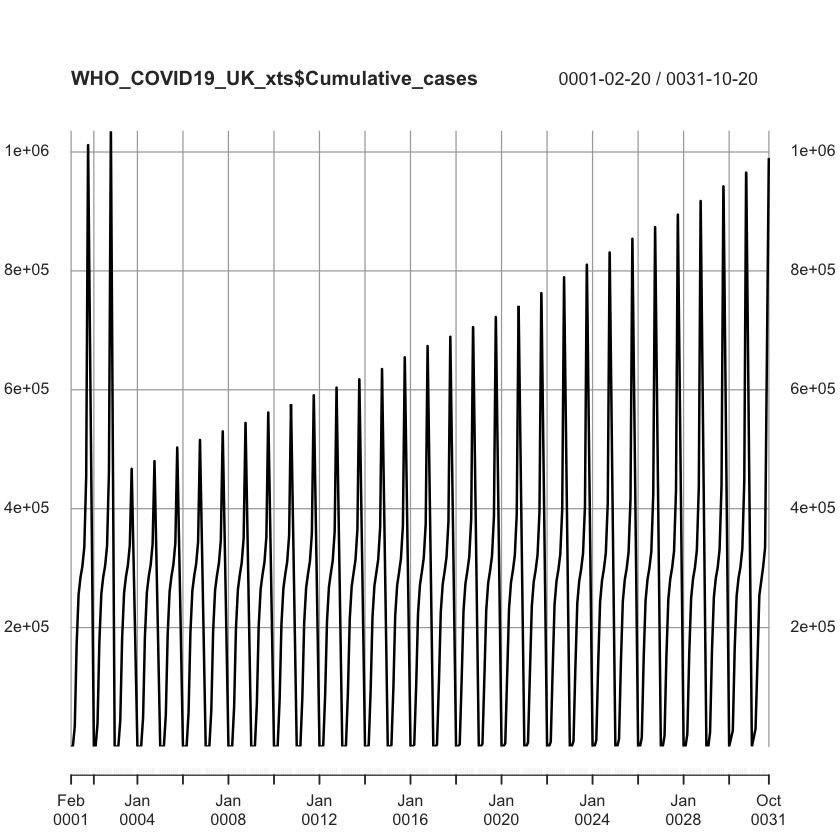

In [48]:
#VISUALISATION OF THE WHO_COVID19_UK_xts DATA
plot.xts(WHO_COVID19_UK_xts$Cumulative_cases)

In [50]:
#Calculate percentage of COVID cases contracted each month
WHO_COVID19_UK_xts$pct_new <- (WHO_COVID19_UK_xts$New_cases / WHO_COVID19_UK_xts$Cumulative_cases) * 100

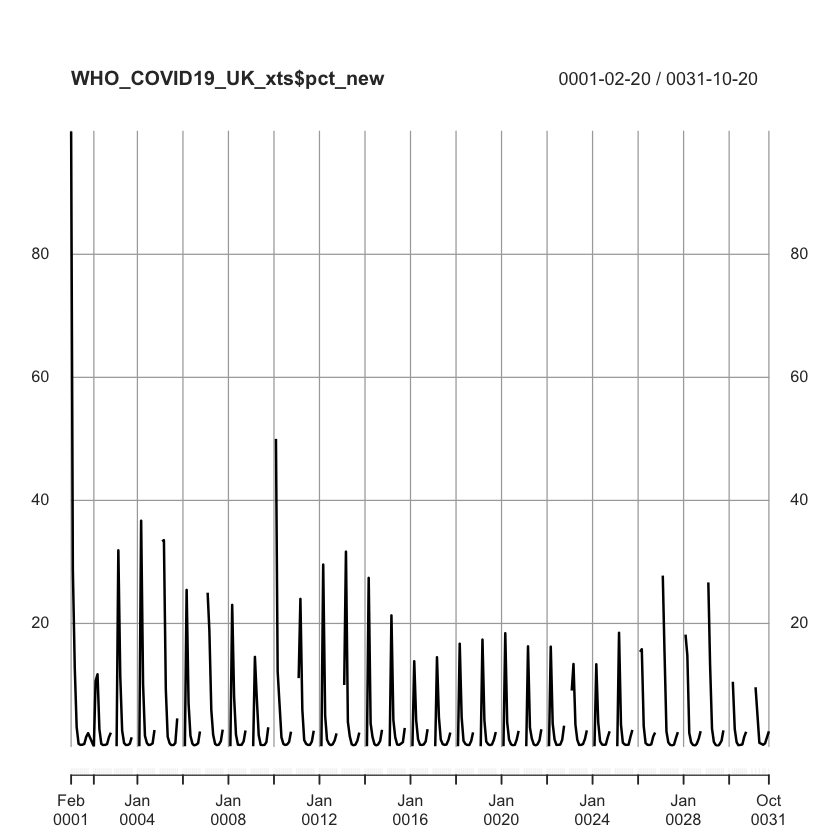

In [51]:
#Plot/view the percentage new COVID cases over time
plot.xts(WHO_COVID19_UK_xts$pct_new)

In [52]:
#Save xts object to RDS file
saveRDS(object = WHO_COVID19_UK_xts, file = "WHO_COVID19_UK_xts.rds")

#Read in your data from the rds file
WHO_COVID19_UK_xts2 <- readRDS("WHO_COVID19_UK_xts.rds")

#Check class of new xts2 object
class(WHO_COVID19_UK_xts2)

#Examine first 5 rows of new xts2 object 
head(WHO_COVID19_UK_xts2, n = 5)

[1] "xts" "zoo"

           New_cases Cumulative_cases New_deaths Cumulative_deaths     pct_new
0001-02-20         2                2          0                 0 100.0000000
0001-03-20        12               42          0                 0  28.5714286
0001-04-20      4273            33954        403              2453  12.5846734
0001-05-20      5446           172596        634             26683   3.1553454
0001-06-20      1125           255519         60             37445   0.4402804

In [54]:
# Export xts object to csv file 
write.zoo(WHO_COVID19_UK_xts, file = "WHO_COVID19_UK_xts.csv", sep = ",")

#Open saved object using read.zoo
COVID19_xts2 <- read.zoo("WHO_COVID19_UK_xts.csv", sep = ",", FUN = as.Date, header = TRUE, index.column = 1)

#Encode new object back into xts
WHO_COVID19_UK_xts2 <- as.xts(COVID19_xts2)

#Examine first 5 rows of new xts2 object
head(WHO_COVID19_UK_xts2, n = 5)

           New_cases Cumulative_cases New_deaths Cumulative_deaths     pct_new
0001-02-20         2                2          0                 0 100.0000000
0001-03-20        12               42          0                 0  28.5714286
0001-04-20      4273            33954        403              2453  12.5846734
0001-05-20      5446           172596        634             26683   3.1553454
0001-06-20      1125           255519         60             37445   0.4402804